# Spectral Analysis of Fine-tuned Language Models

## Overview

This notebook demonstrates how to use **WeightWatcher** to analyze the training quality of fine-tuned language models through **Random Matrix Theory** and spectral analysis.

### What We'll Do

1. **Load and Prepare Data**: Download the IR Triplets dataset for inductive reasoning
2. **Fine-tune a Language Model**: Train DistilGPT2 on question-answering task
3. **Spectral Analysis**: Use WeightWatcher to compute power law exponents (α) for each layer
4. **Visualize Results**: Analyze how model quality evolves during training

### Key Concepts

**WeightWatcher** analyzes the weight matrices of neural networks using Random Matrix Theory:
- Computes the **power law exponent (α)** for each layer
- α indicates training quality:
  - **2 ≤ α ≤ 6**: Well-trained layer
  - **α < 2**: Over-trained (memorization)
  - **α > 6**: Under-trained (needs more training)

### Model and Dataset

- **Model**: DistilGPT2 (82M parameters) - A smaller, faster version of GPT-2
- **Dataset**: IR Triplets - Inductive reasoning examples with Context/Question/Answer
- **Task**: Fine-tune for question answering given context

### References

- WeightWatcher: https://github.com/CalculatedContent/WeightWatcher
- IR Triplets Dataset: https://github.com/omroot/InductiveSLM
- Paper: "Inductive Reasoning in Large Language Models"


## Step 1: Setup and Imports

First, we'll import all necessary libraries and set up our environment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../../../')

# HuggingFace Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from datasets import Dataset

# Our utility functions
from src.dlf.theory.spectral_analysis import (
    download_ir_triplets,
    format_dataset,
    analyze_model_with_weightwatcher,
    analyze_all_checkpoints,
    prepare_visualization_data,
    create_spectral_analysis_plots,
    create_summary_table,
    print_key_findings,
)

print("✓ All libraries imported successfully")

PyTorch is available but CUDA is not. Defaulting to NumPy for SVD
Import error , reetting to svd accurate methods


Running on macOS.
Running on macOS.
✓ All libraries imported successfully


## Step 2: Configuration

Set up our experiment parameters and visualization styles.

In [3]:
# Visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Experiment configuration
SEED = 42
MODEL_NAME = "distilgpt2"  # 82M parameter model
MAX_LENGTH = 512  # Maximum sequence length
NUM_EPOCHS = 2  # Number of training epochs
BATCH_SIZE = 8  # Training batch size
OUTPUT_DIR = "./finetuned_distilgpt2_model"

# Set random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {device}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max length: {MAX_LENGTH}")
print(f"  Random seed: {SEED}")

Configuration:
  Model: distilgpt2
  Device: cpu
  Epochs: 2
  Batch size: 8
  Max length: 512
  Random seed: 42


## Step 3: Load and Explore the Dataset

The **IR Triplets** dataset contains examples for inductive reasoning. Each example has:
- **Training Observations** (Context): Background information
- **Question**: What to predict or infer
- **Answer**: The correct answer

We'll download the dataset and split it into train/test sets (80/20 split).

In [4]:
print("="*80)
print("DOWNLOADING AND PREPARING DATASET")
print("="*80)

# Download and split dataset
triplets_data = download_ir_triplets(test_fraction=0.2, seed=SEED)

# Print statistics
print("\nDataset Statistics:")
print(f"  Train: {len(triplets_data['train']):4d} examples")
print(f"  Test:  {len(triplets_data['test']):4d} examples")
print(f"  Total: {len(triplets_data['train']) + len(triplets_data['test']):4d} examples")

# Show example
print("\n" + "="*80)
print("EXAMPLE FROM DATASET")
print("="*80)
example = triplets_data['train'][0]
print(f"\nType: {example.get('form', 'N/A')}")
print(f"\nContext (Training Observations):\n  {example['Training Observations'][:200]}...")
print(f"\nQuestion:\n  {example['Question']}")
print(f"\nAnswer:\n  {example['Answer'][:200]}...")

DOWNLOADING AND PREPARING DATASET

Dataset Statistics:
  Train: 1446 examples
  Test:   361 examples
  Total: 1807 examples

EXAMPLE FROM DATASET

Type: Predictive induction

Context (Training Observations):
  Series exhibits strong persistence (lag-1 ≈ 0.95), a decade-long upward trend (+13.2%), and weak seasonality, with shocks being rare but impactful....

Question:
  Absent new shocks, what should be expected for the month after 2009-12?

Answer:
  A value near the prevailing trend with only modest seasonal deviation—continued gradual growth unless disrupted....


## Step 4: Format Data for Causal Language Modeling

For causal language models like DistilGPT2, we need to format our data as a single text string.

We'll use the format:
```
Context: {Training Observations}

Question: {Question}

Answer: {Answer}
```

The model will learn to predict the next token given the previous tokens, effectively learning to answer questions given context.

In [5]:
print("Formatting datasets for causal LM training...")

# Format both train and test
train_formatted = format_dataset(triplets_data['train'])
test_formatted = format_dataset(triplets_data['test'])

print(f"✓ Formatted {len(train_formatted)} training examples")
print(f"✓ Formatted {len(test_formatted)} test examples")

# Show formatted example
print("\n" + "="*80)
print("FORMATTED EXAMPLE")
print("="*80)
print(train_formatted[0]['text'][:400] + "...")

Formatting datasets for causal LM training...
✓ Formatted 1446 training examples
✓ Formatted 361 test examples

FORMATTED EXAMPLE
Context: Series exhibits strong persistence (lag-1 ≈ 0.95), a decade-long upward trend (+13.2%), and weak seasonality, with shocks being rare but impactful.

Question: Absent new shocks, what should be expected for the month after 2009-12?

Answer: A value near the prevailing trend with only modest seasonal deviation—continued gradual growth unless disrupted....


## Step 5: Load Pre-trained Model and Tokenizer

We'll use **DistilGPT2**, a distilled version of GPT-2:
- **82M parameters** (much smaller than GPT-2's 124M)
- **Faster training** and inference
- **Same architecture** as GPT-2, just smaller

The tokenizer converts text to token IDs that the model can process.

In [6]:
print("="*80)
print("LOADING MODEL AND TOKENIZER")
print("="*80)

print(f"\nLoading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# Set pad token (GPT-2 doesn't have one by default)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("  Set pad_token = eos_token")

# Move model to device
model = model.to(device)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / (1024**2):.1f} MB (float32)")

LOADING MODEL AND TOKENIZER

Loading distilgpt2...
  Set pad_token = eos_token

✓ Model loaded successfully
  Total parameters: 81,912,576
  Trainable parameters: 81,912,576
  Model size: ~312.5 MB (float32)


## Step 6: Tokenize the Datasets

Convert our text data into token IDs that the model can process.

We'll:
1. Truncate sequences longer than MAX_LENGTH (512 tokens)
2. Pad sequences shorter than MAX_LENGTH
3. Create attention masks to ignore padding

In [7]:
print("="*80)
print("TOKENIZING DATASETS")
print("="*80)

def tokenize_function(examples):
    """Tokenize text with truncation and padding."""
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length"
    )

# Create HuggingFace datasets
train_dataset = Dataset.from_list(train_formatted)
test_dataset = Dataset.from_list(test_formatted)

print("\nTokenizing...")
# Tokenize
train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    desc="Tokenizing train"
)
test_dataset = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    desc="Tokenizing test"
)

print(f"\n✓ Datasets tokenized")
print(f"  Training: {len(train_dataset)} examples")
print(f"  Test: {len(test_dataset)} examples")
print(f"  Token sequence length: {MAX_LENGTH}")

TOKENIZING DATASETS

Tokenizing...


Tokenizing train:   0%|          | 0/1446 [00:00<?, ? examples/s]

Tokenizing test:   0%|          | 0/361 [00:00<?, ? examples/s]


✓ Datasets tokenized
  Training: 1446 examples
  Test: 361 examples
  Token sequence length: 512


## Step 7: Analyze Pre-trained Model with WeightWatcher

Before fine-tuning, let's analyze the **pre-trained** model to establish a baseline.

WeightWatcher will:
1. Extract weight matrices from each layer
2. Compute eigenvalues via Singular Value Decomposition (SVD)
3. Fit a power law to the eigenvalue distribution
4. Report the power law exponent (α) for each layer

This gives us insight into the quality of the pre-trained weights.

In [8]:
print("="*80)
print("ANALYZING PRE-TRAINED MODEL (Checkpoint 0)")
print("="*80)

# Analyze pre-trained model
checkpoint_results = {}
checkpoint_results['checkpoint_0_pretrained'] = analyze_model_with_weightwatcher(
    model,
    model_name="checkpoint_0_pretrained",
    device=device
)

print("\n✓ Pre-trained model analysis complete")

ANALYZING PRE-TRAINED MODEL (Checkpoint 0)

Analyzing checkpoint_0_pretrained with WeightWatcher...
  ✓ Saved to weightwatcher_checkpoint_0_pretrained.csv
  ✓ Analysis complete
    Layers analyzed: 25
    Mean α: 4.028
    Good layers (2 ≤ α ≤ 6): 21/25

✓ Pre-trained model analysis complete


## Step 8: Fine-tune the Model

Now we'll fine-tune DistilGPT2 on our question-answering task.

### Training Configuration

- **Objective**: Causal language modeling (predict next token)
- **Epochs**: 2 (for demonstration; more epochs would improve performance)
- **Batch Size**: 8
- **Optimizer**: AdamW with weight decay
- **Learning Rate Schedule**: Linear warmup for 50 steps
- **Evaluation**: Every epoch on the test set
- **Checkpointing**: Save model after each epoch

### What the Model Learns

By training on our formatted text, the model learns:
1. To recognize the Context → Question → Answer pattern
2. To generate appropriate answers given context and questions
3. To perform inductive reasoning based on observations

In [9]:
print("="*80)
print("FINE-TUNING MODEL")
print("="*80)

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save checkpoint after each epoch
    save_total_limit=NUM_EPOCHS,  # Keep all checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    seed=SEED,
    report_to="none",  # Don't report to wandb/tensorboard
)

# Data collator for causal LM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # False = Causal LM, True = Masked LM
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

print("\nStarting training...")
print("-"*80)

# Train!
train_result = trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"  Training loss: {train_result.training_loss:.4f}")

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(test_dataset)

print(f"\n✓ Test set evaluation:")
print(f"  Loss: {test_results.get('eval_loss', 0):.4f}")
print(f"  Perplexity: {np.exp(test_results.get('eval_loss', 0)):.2f}")

print("\nNote: Lower loss and perplexity indicate better performance.")

FINE-TUNING MODEL

Starting training...
--------------------------------------------------------------------------------


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,3.070500,2.793941
2,2.705800,2.672042


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



TRAINING COMPLETE
  Training loss: 3.1119

Evaluating on test set...



✓ Test set evaluation:
  Loss: 2.6720
  Perplexity: 14.47

Note: Lower loss and perplexity indicate better performance.


## Step 9: Analyze All Checkpoints

Now we'll analyze each saved checkpoint with WeightWatcher to see how the model's internal structure evolved during training.

For each checkpoint, we'll:
1. Load the saved model
2. Evaluate it on the test set (loss and perplexity)
3. Run WeightWatcher analysis (compute α for all layers)
4. Save the results

To save time, we'll analyze every 2nd checkpoint by default.

In [10]:
# Analyze all checkpoints
checkpoint_results_from_analysis = analyze_all_checkpoints(
    output_dir=OUTPUT_DIR,
    trainer=trainer,
    test_dataset=test_dataset,
    data_collator=data_collator,
    training_args=training_args,
    device=device,
    analyze_every_n=2  # Analyze every 2nd checkpoint
)

# Merge with pre-trained results
checkpoint_results.update(checkpoint_results_from_analysis)

# Also analyze the final model
print(f"\nAnalyzing final fine-tuned model...")
final_results = analyze_model_with_weightwatcher(
    model,
    model_name="checkpoint_final",
    device=device
)
final_results['loss'] = test_results.get('eval_loss', 0)
final_results['perplexity'] = np.exp(test_results.get('eval_loss', 0))
checkpoint_results['checkpoint_final'] = final_results

print(f"\n✓ Analyzed {len(checkpoint_results)} total checkpoints")

ANALYZING ALL CHECKPOINTS
Found 2 checkpoints
Analyzing every 2 checkpoint(s) to save time...
--------------------------------------------------------------------------------

Checkpoint 1: ./finetuned_distilgpt2_model/checkpoint-181


  Loss: 2.7939
  Perplexity: 16.35

Analyzing checkpoint_181 with WeightWatcher...
  ✓ Saved to weightwatcher_checkpoint_181.csv
  ✓ Analysis complete
    Layers analyzed: 25
    Mean α: 4.027
    Good layers (2 ≤ α ≤ 6): 21/25

Analyzing final fine-tuned model...

Analyzing checkpoint_final with WeightWatcher...
  ✓ Saved to weightwatcher_checkpoint_final.csv
  ✓ Analysis complete
    Layers analyzed: 25
    Mean α: 4.027
    Good layers (2 ≤ α ≤ 6): 21/25

✓ Analyzed 3 total checkpoints


## Step 10: Visualize Results

Let's create visualizations to understand how the model evolved during training.

We'll create a 4-panel plot showing:
1. **Power Law Exponent (α) Evolution**: How layer quality changed
2. **Test Loss Evolution**: How well the model fits the data
3. **Perplexity Evolution**: How "surprised" the model is by the test data
4. **α vs Loss Correlation**: Relationship between spectral properties and performance

CREATING VISUALIZATIONS

Prepared data for 3 checkpoints
✓ Saved distilgpt2_spectral_analysis.png


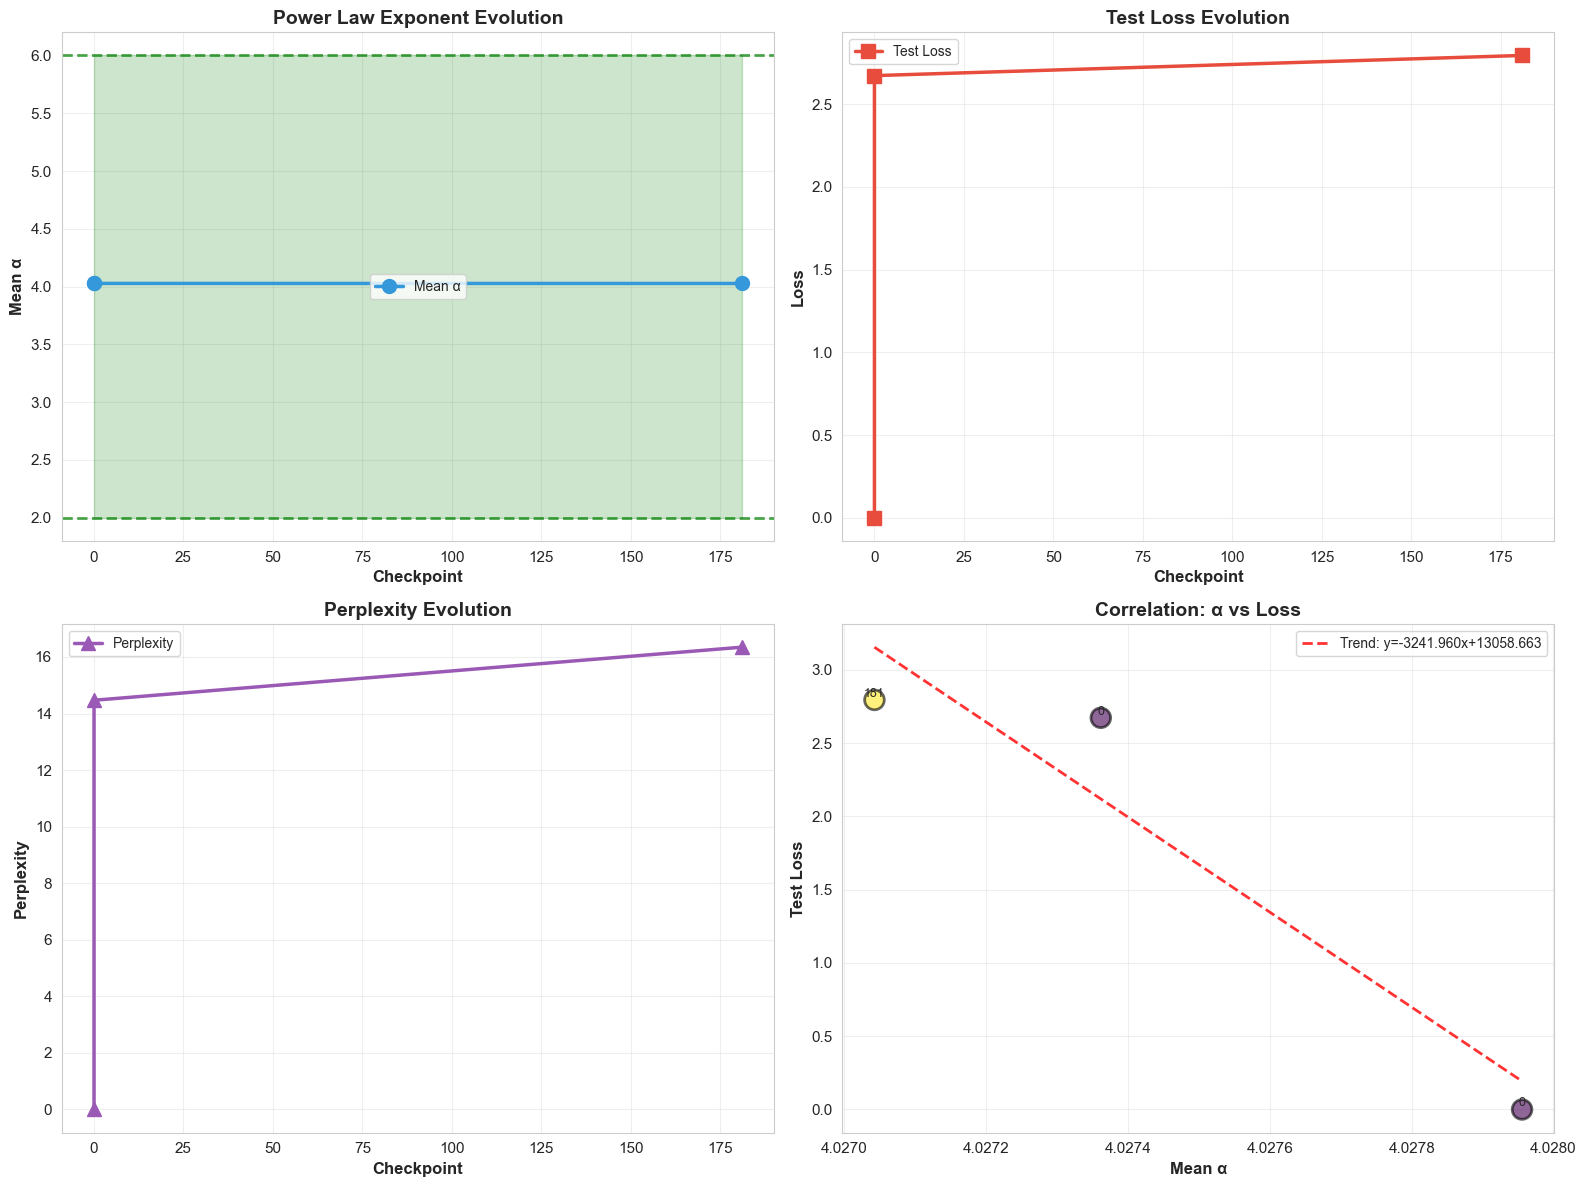


✓ Visualization complete


In [11]:
print("="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Prepare data for visualization
viz_data = prepare_visualization_data(checkpoint_results)
print(f"\nPrepared data for {len(viz_data['checkpoint_names'])} checkpoints")

# Create plots
fig = create_spectral_analysis_plots(
    viz_data,
    save_path='distilgpt2_spectral_analysis.png',
    figsize=(16, 12),
    dpi=150
)

plt.show()

print("\n✓ Visualization complete")

## Step 11: Summary Table

Create a summary table of all checkpoints with key metrics.

In [12]:
print("="*80)
print("ANALYSIS SUMMARY TABLE")
print("="*80)

summary_df = create_summary_table(
    checkpoint_results,
    save_path='weightwatcher_summary.csv'
)

print("\n" + summary_df.to_string(index=False))

ANALYSIS SUMMARY TABLE

✓ Summary saved to weightwatcher_summary.csv

             Checkpoint  CP#   Loss Perplexity Mean α Good Layers
checkpoint_0_pretrained    0 0.0000       0.00  4.028       21/25
       checkpoint_final    0 2.6720      14.47  4.027       21/25
         checkpoint_181  181 2.7939      16.35  4.027       21/25


## Step 12: Key Findings

Let's extract and interpret the key findings from our analysis.

In [13]:
print_key_findings(viz_data)

KEY FINDINGS

1. BEST PERFORMING CHECKPOINT (Lowest Loss):
   Checkpoint: checkpoint_0_pretrained
   Loss: 0.0000
   Perplexity: 0.00
   Mean α: 4.028

2. CORRELATION ANALYSIS:
   α vs Loss: -0.951
   Strong negative correlation: Lower α → Higher loss

3. TRAINING EVOLUTION:
   Initial mean α: 4.028
   Final mean α: 4.027
   Change: -0.001

   Initial loss: 0.0000
   Final loss: 2.7939
   Improvement: -2.7939



## Step 13: Interpretation

### What Do These Results Mean?

#### Power Law Exponent (α)

The power law exponent α characterizes the distribution of singular values in weight matrices:
- **α ≈ 2-6**: Indicates well-regularized, generalizable layers
- **α < 2**: Suggests over-training or memorization
- **α > 6**: Suggests under-training or poor optimization

#### Loss and Perplexity

- **Loss**: Cross-entropy loss on test set (lower is better)
- **Perplexity**: exp(loss), interpretable as "how many choices the model is uncertain between" (lower is better)

#### Correlation Analysis

- **Negative correlation** between α and loss: Higher quality layers (lower α in the good range) tend to produce lower loss
- **Positive correlation**: The opposite relationship
- **No correlation**: Spectral properties don't directly predict performance

### Practical Implications

1. **Training Progress**: If α values improve during training, the model is learning good representations
2. **Over-training Detection**: If α drops below 2, the model may be memorizing
3. **Layer-wise Diagnosis**: Individual layer α values can identify problematic layers
4. **Early Stopping**: Can use α evolution as an additional criterion for when to stop training

## Conclusion

In this notebook, we:

1. ✅ Loaded and prepared the IR Triplets dataset
2. ✅ Fine-tuned DistilGPT2 on question-answering
3. ✅ Analyzed model quality using WeightWatcher at multiple checkpoints
4. ✅ Visualized the evolution of spectral properties during training
5. ✅ Correlated spectral analysis with model performance

### Key Takeaways

- **WeightWatcher provides insights** into model quality beyond traditional metrics
- **Power law exponent (α)** is a useful indicator of layer training quality
- **Spectral analysis** can help diagnose over-training, under-training, and optimization issues
- **Combining traditional metrics** (loss, perplexity) with spectral analysis gives a more complete picture

### Generated Files

- `distilgpt2_spectral_analysis.png` - 4-panel visualization
- `weightwatcher_summary.csv` - Summary table
- `weightwatcher_checkpoint_*.csv` - Detailed layer-wise analysis for each checkpoint
- `./finetuned_distilgpt2_model/` - Saved model checkpoints

### Next Steps

- Try different architectures (GPT-2, GPT-2-medium, etc.)
- Experiment with more epochs to see long-term α evolution
- Compare α values across different datasets
- Use layer-wise α values to identify and fix problematic layers